In [1]:
import os
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.models as models
from torch.utils.data import Subset, DataLoader
from torchvision.datasets import ImageFolder
import matplotlib.pyplot as plt
import numpy as np
from simple_cnn import SimpleCNN
from torch.optim.lr_scheduler import StepLR, ReduceLROnPlateau

In [2]:
# Transformations: Resize, Normalize
transform_main_model = transforms.Compose([
    transforms.Resize((128, 128)),  # Resize to fixed size
    transforms.ToTensor(),          # Convert to tensor
    transforms.Normalize((0.5,), (0.5,))  # Normalize to [-1, 1]
])

In [3]:
# --- Dataset base (senza transform) ---
dataset = ImageFolder(root='../../IAM+RIMES')  # nessuna transform qui

# --- Carica lo split ---
#split = torch.load('splits/dataset_split.pth')
#train_indices = split['train_indices']
#val_indices = split['val_indices']
split = torch.load('splits/IAM+RIMES.pth')

train_indices = split['train_indices']
test_indices = split['test_indices']
label_map = split['label_map']

print(f"Numero train samples: {len(train_indices)}")
print(f"Numero test samples: {len(test_indices)}")
print(f"Numero classi (label ricodificati): {len(label_map)}")

# --- Applica lo split ---
train_subset = Subset(dataset, train_indices)
val_subset = Subset(dataset, test_indices)

class TransformedSubset(torch.utils.data.Dataset):
    def __init__(self, subset, transform, label_map):
        self.subset = subset
        self.transform = transform
        self.label_map = label_map  # dizionario {label_originale: label_ricodificato}
    def __getitem__(self, idx):
        img, label = self.subset[idx]
        if label in self.label_map:
            mapped_label = self.label_map[label]
        else:
            # Label non autorizzata, assegna -1 o altra label "speciale"
            mapped_label = -1
        return self.transform(img), mapped_label

    def __len__(self):
        return len(self.subset)

# --- Applica le trasformazioni specifiche ---
train_data = TransformedSubset(train_subset, transform_main_model, label_map)

# --- Calcola il numero di classi a partire dal training set ---
all_labels = [label for _, label in train_subset]

num_classes = len(label_map)
print(f"Numero di classi (utenti autorizzati): {num_classes}")

val_data = TransformedSubset(val_subset, transform_main_model, label_map)

train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
val_loader = DataLoader(val_data, batch_size=32, shuffle=False)

Numero train samples: 550
Numero test samples: 150
Numero classi (label ricodificati): 100
Numero di classi (utenti autorizzati): 100


In [4]:
# Initialize the model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = SimpleCNN(num_classes=num_classes).to(device)

c:\Users\Giuseppe\anaconda3\envs\bio_env\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Giuseppe\anaconda3\envs\bio_env\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [5]:
# Step 3: Define Loss and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
#scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.1, patience=3)

In [6]:
all_labels = [label for _, label in train_subset]
num_classes = len(set(all_labels))
print(num_classes)
print(min(all_labels), max(all_labels))


100
25 1741


In [7]:
import torch.nn.functional as F

num_epochs = 25
threshold = 0.6  # soglia di confidenza per accettare la predizione

train_losses = []
train_accuracies = []
val_auth_accuracies = []
val_far_rates = []
val_frr_rates = []
val_overall_accuracies = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Metrics on train batch
        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct_train += (predicted == labels).sum().item()
        total_train += labels.size(0)

    train_losses.append(running_loss / len(train_loader))
    train_accuracies.append(100 * correct_train / total_train)

    # Validation estesa con soglia
    model.eval()
    correct_auth = 0
    total_auth = 0
    false_accepts = 0
    false_rejects = 0
    total_unauth = 0
    total_test = 0
    correct_total = 0
    confidence_sum = 0.0
    confidence_count = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            
            probs = F.softmax(outputs, dim=1)
            max_probs, predicted = torch.max(probs, 1)

            for i in range(labels.size(0)):
                label = labels[i].item()
                pred = predicted[i].item()
                conf = max_probs[i].item()

                # 🔢 Accumula confidenza per media
                confidence_sum += conf
                confidence_count += 1

                # Se confidenza sotto soglia => consideriamo "non autorizzato" (-1)
                if conf < threshold:
                    pred = -1

                if label == -1:  # Utente non autorizzato
                    total_unauth += 1
                    if pred != -1:  # falso accetto
                        false_accepts += 1
                else:  # Utente autorizzato
                    total_auth += 1
                    if pred == label:
                        correct_auth += 1
                    else:
                        false_rejects += 1

                # Accuratezza globale
                if (label != -1 and pred == label) or (label == -1 and pred == -1):
                    correct_total += 1
                total_test += 1

    auth_acc = 100 * correct_auth / total_auth if total_auth > 0 else 0
    far = 100 * false_accepts / total_unauth if total_unauth > 0 else 0
    frr = 100 * false_rejects / total_auth if total_auth > 0 else 0
    overall_acc = 100 * correct_total / total_test if total_test > 0 else 0
    # 📊 Calcola confidenza media
    avg_confidence = confidence_sum / confidence_count if confidence_count > 0 else 0.0

    val_auth_accuracies.append(auth_acc)
    val_far_rates.append(far)
    val_frr_rates.append(frr)
    val_overall_accuracies.append(overall_acc)

    print(f"Epoch [{epoch+1}/{num_epochs}]")
    print(f"total_auth: {total_auth}")
    print(f"total_unauth: {total_unauth}")
    print(f"  Loss: {running_loss/len(train_loader):.4f}")
    print(f"  Train Accuracy: {train_accuracies[-1]:.2f}%")
    print(f"  Validation Auth Accuracy: {auth_acc:.2f}%")
    print(f"  Validation FAR (False Accept Rate): {far:.2f}%")
    print(f"  Validation FRR (False Reject Rate): {frr:.2f}%")
    print(f"  Validation Overall Accuracy: {overall_acc:.2f}%")
    print(f"  AVG Confidence: {avg_confidence:.2f}%")
    print("--------------------------------------------------")

    #scheduler.step(val_overall_accuracies[-1])
    #print(f"Learning rate: {optimizer.param_groups[0]['lr']}")


Epoch [1/25]
total_auth: 100
total_unauth: 50
  Loss: 3.8640
  Train Accuracy: 18.00%
  Validation Auth Accuracy: 3.00%
  Validation FAR (False Accept Rate): 34.00%
  Validation FRR (False Reject Rate): 97.00%
  Validation Overall Accuracy: 24.00%
  AVG Confidence: 0.52%
--------------------------------------------------
Epoch [2/25]
total_auth: 100
total_unauth: 50
  Loss: 1.8478
  Train Accuracy: 54.73%
  Validation Auth Accuracy: 4.00%
  Validation FAR (False Accept Rate): 40.00%
  Validation FRR (False Reject Rate): 96.00%
  Validation Overall Accuracy: 22.67%
  AVG Confidence: 0.49%
--------------------------------------------------
Epoch [3/25]
total_auth: 100
total_unauth: 50
  Loss: 0.9308
  Train Accuracy: 77.27%
  Validation Auth Accuracy: 14.00%
  Validation FAR (False Accept Rate): 54.00%
  Validation FRR (False Reject Rate): 86.00%
  Validation Overall Accuracy: 24.67%
  AVG Confidence: 0.59%
--------------------------------------------------
Epoch [4/25]
total_auth: 100
t

In [8]:
torch.save(model.state_dict(), 'base_model.pth')

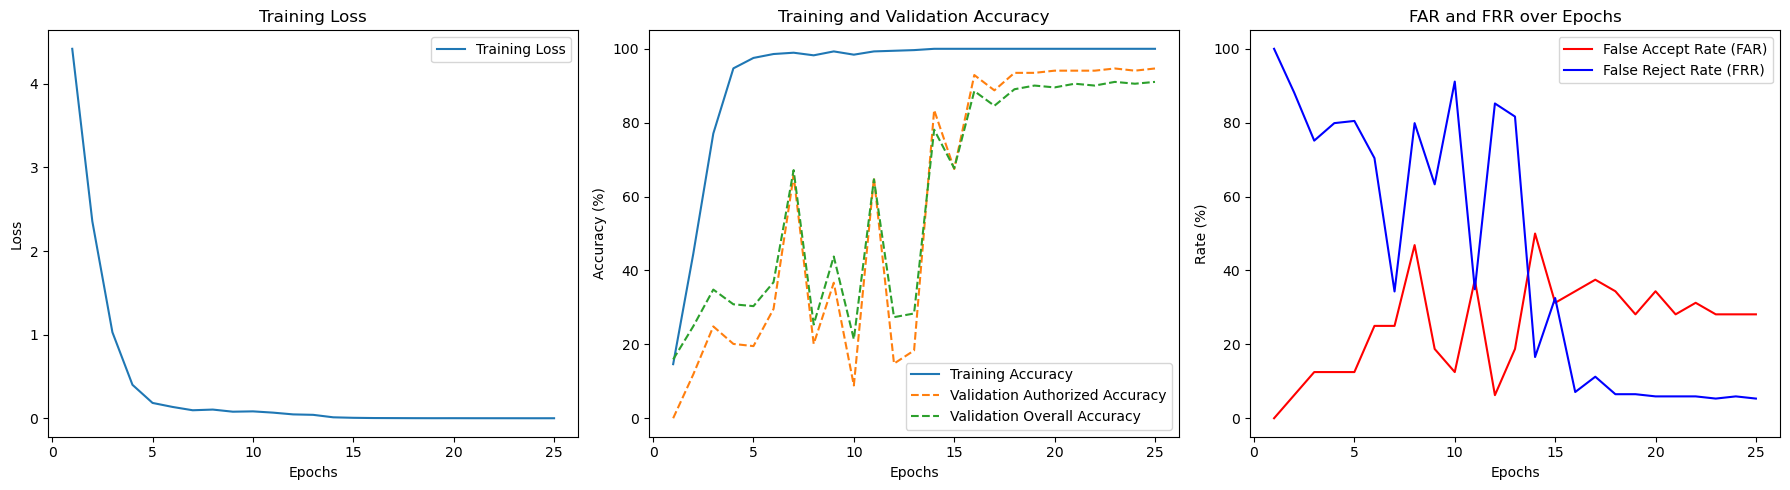

In [19]:
# Step 5: Plot Training and Validation Metrics
epochs = range(1, num_epochs + 1)

plt.figure(figsize=(18, 5))  # Allarga la figura per accomodare 3 subplot

# Plot 1 - Training Loss
plt.subplot(1, 3, 1)
plt.plot(epochs, train_losses, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()

# Plot 2 - Training and Validation Accuracy
plt.subplot(1, 3, 2)
plt.plot(epochs, train_accuracies, label='Training Accuracy')
plt.plot(epochs, val_auth_accuracies, label='Validation Authorized Accuracy', linestyle='--')
plt.plot(epochs, val_overall_accuracies, label='Validation Overall Accuracy', linestyle='--')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Training and Validation Accuracy')
plt.legend()

# Plot 3 - FAR and FRR
plt.subplot(1, 3, 3)
plt.plot(epochs, val_far_rates, label='False Accept Rate (FAR)', color='red')
plt.plot(epochs, val_frr_rates, label='False Reject Rate (FRR)', color='blue')
plt.xlabel('Epochs')
plt.ylabel('Rate (%)')
plt.title('FAR and FRR over Epochs')
plt.legend()

plt.tight_layout()
plt.show()
